# Семинар 5: Подбор гиперпараметров

В этом семинаре мы рассмотрим различные методы подбора гиперпараметров для моделей машинного обучения:
1. Правильное разделение данных для подбора гиперпараметров
2. Grid Search (поиск по сетке)
3. Random Search (случайный поиск)
4. Bayesian Optimization с помощью Optuna

Мы будем использовать датасет Student Depression для демонстрации этих методов.

In [ ]:
# Установка необходимых библиотек
!pip install pandas numpy scikit-learn catboost optuna

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report
from catboost import CatBoostClassifier
import optuna

# Для воспроизводимости результатов
np.random.seed(42)

c:\Users\hehen\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[general](https://yastatic.net/s3/education-portal/media/8_2_b6c8676778_ef9b0cebbe.webp)

## 1. Загрузка и подготовка данных

Сначала загрузим Student Depression dataset и выполним базовую предобработку.

In [2]:
df = pd.read_csv('student_depression.csv')
print("Размер датасета:", df.shape)
df.head()

Размер датасета: (27901, 18)


,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0


## 2. Разделение данных

При подборе гиперпараметров важно правильно разделить данные на три части:
- Тренировочная выборка (train) - для обучения модели
- Валидационная выборка (validation) - для подбора гиперпараметров
- Тестовая выборка (test) - для финальной оценки модели

Это помогает избежать переобучения и получить честную оценку качества модели.

In [3]:
# Подготовка данных
X = df.drop('Depression', axis=1)
y = df['Depression']

# Сначала отделяем тестовую выборку
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Затем разделяем оставшиеся данные на train и validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

print(f"Размеры выборок:\nTrain: {X_train.shape}\nValidation: {X_val.shape}\nTest: {X_test.shape}")

Размеры выборок:
Train: (16740, 17)
Validation: (5580, 17)
Test: (5581, 17)


## 2.1 Кросс-валидация (Cross-validation)

Кросс-валидация - это более продвинутый метод оценки качества модели, который помогает получить более надежную оценку производительности модели.

Основные виды кросс-валидации:
1. K-fold Cross-validation
2. Stratified K-fold Cross-validation
3. Leave-One-Out Cross-validation
4. Time Series Cross-validation

Давайте рассмотрим их подробнее.

[crossval](https://yastatic.net/s3/education-portal/media/8_3_715a0c2b1d_7a496fcd6e.webp)

In [8]:
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, TimeSeriesSplit
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Базовая модель для демонстрации
base_model = CatBoostClassifier(
    iterations=100, verbose=False, random_state=42
)

### K-fold Cross-validation

При K-fold кросс-валидации данные разбиваются на K равных частей. Модель обучается K раз, каждый раз используя K-1 частей для обучения и 1 часть для валидации.

C:\Users\hehen\AppData\Local\Temp\ipykernel_2756\3249085619.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\hehen\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


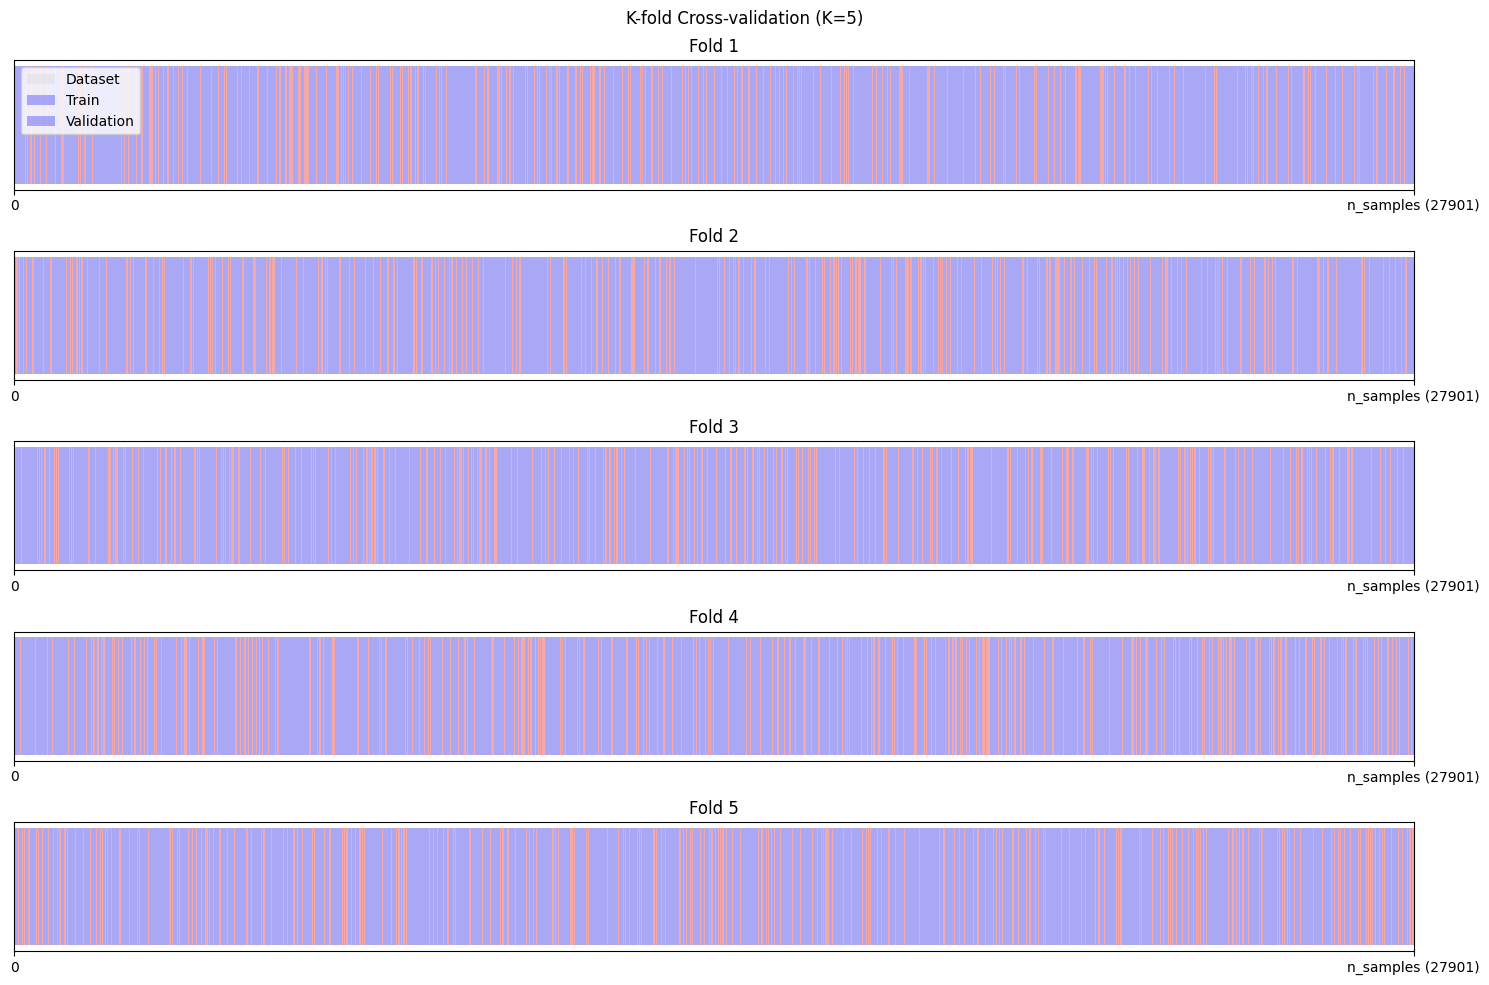

K-fold CV scores: [0.8407095502598101, 0.8514336917562724, 0.8516129032258064, 0.8415770609318997, 0.8553763440860215]
Mean accuracy: 0.8481 ± 0.0059


In [9]:
def plot_kfold_splits(X, kfold, title):
    n_samples = len(X)
    fig, axs = plt.subplots(kfold.n_splits, 1, figsize=(15, 2*kfold.n_splits))
    fig.suptitle(title)

    if isinstance(kfold, StratifiedKFold):
        split_data = kfold.split(X, y)
    else:
        split_data = kfold.split(X)
    
    for idx, (train_idx, val_idx) in enumerate(split_data):
        axs[idx].set_title(f'Fold {idx+1}')
        axs[idx].set_yticks([])
        
        axs[idx].barh(0, n_samples, color='lightgray', alpha=0.3)
        
        for train_block in np.split(train_idx, np.where(np.diff(train_idx) != 1)[0] + 1):
            axs[idx].barh(0, len(train_block), left=train_block[0], color='blue', alpha=0.3)
        
        for val_block in np.split(val_idx, np.where(np.diff(val_idx) != 1)[0] + 1):
            axs[idx].barh(0, len(val_block), left=val_block[0], color='red', alpha=0.3)
        
        if idx == 0:
            axs[idx].legend(['Dataset', 'Train', 'Validation'])
        
        axs[idx].set_xlim(0, n_samples)
        axs[idx].set_xticks([0, n_samples])
        axs[idx].set_xticklabels(['0', f'n_samples ({n_samples})'])
    
    plt.tight_layout()
    plt.show()

# Демонстрация K-fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
plot_kfold_splits(X, kf, 'K-fold Cross-validation (K=5)')

# Оценка модели с помощью K-fold
scores = []
for train_idx, val_idx in kf.split(X):
    X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
    y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = CatBoostClassifier(iterations=100, verbose=False, random_state=42)
    model.fit(X_fold_train, y_fold_train,
                cat_features=['Gender', 'Profession', 'Dietary Habits', 'Degree',
                'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness',
                'Sleep Duration', 'City']
            )
    pred = model.predict(X_fold_val)
    scores.append(accuracy_score(y_fold_val, pred))

print(f"K-fold CV scores: {scores}")
print(f"Mean accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

### Stratified K-fold Cross-validation

Stratified K-fold сохраняет распределение классов в каждом фолде. Это особенно важно при несбалансированных данных.

C:\Users\hehen\AppData\Local\Temp\ipykernel_2756\3249085619.py:30: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
C:\Users\hehen\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


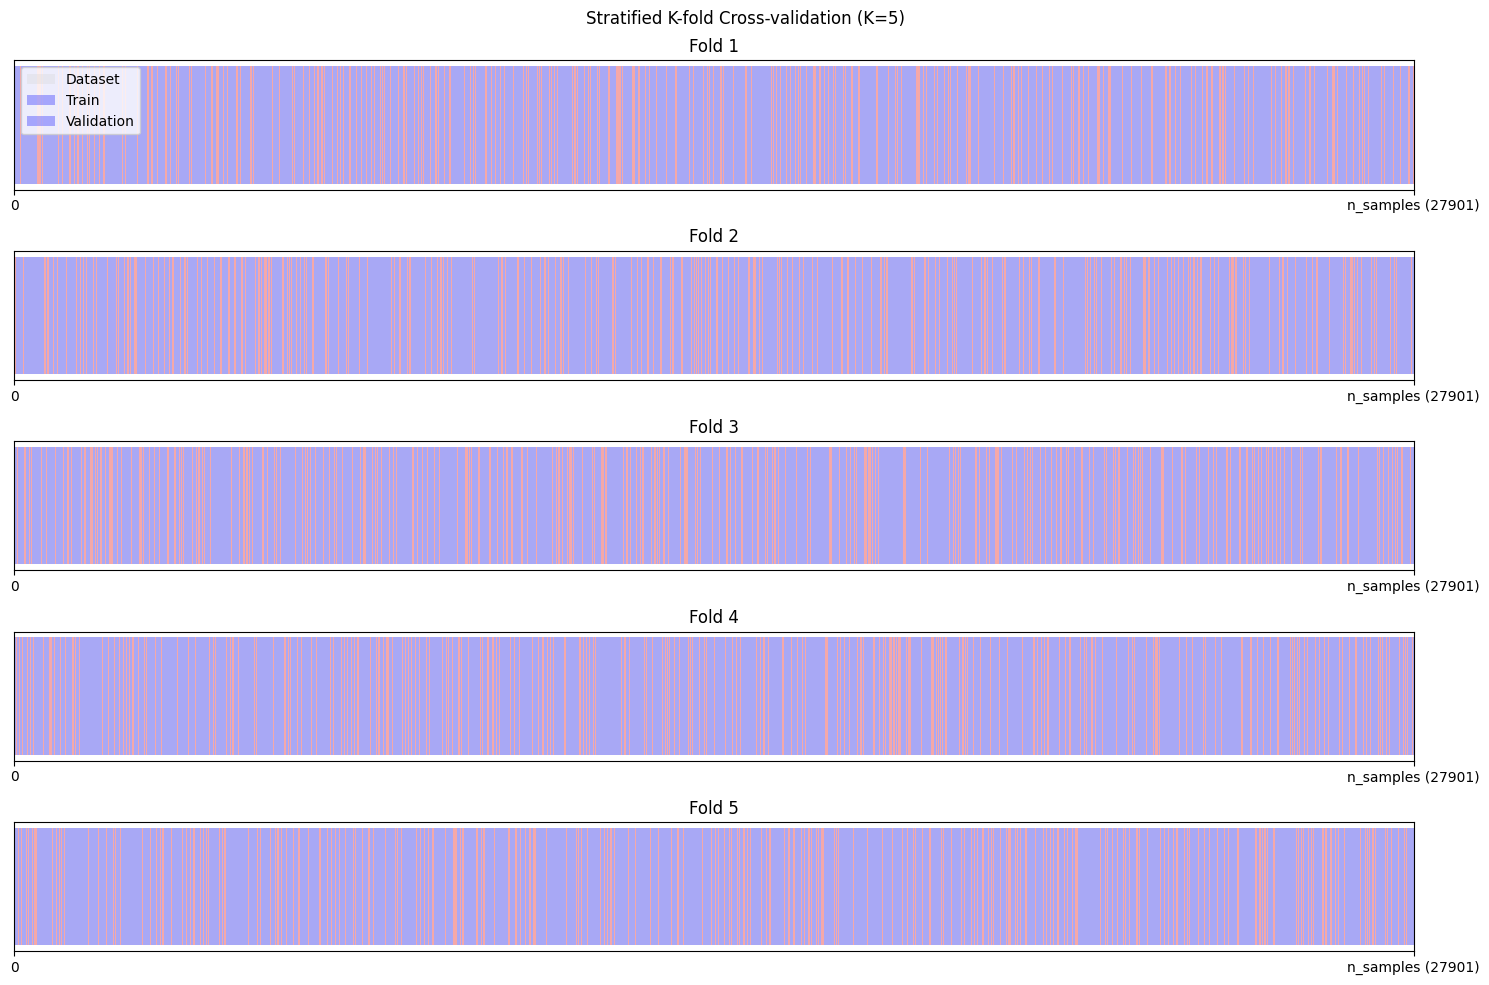

Stratified K-fold CV scores: [0.8500268769037806, 0.8455197132616488, 0.843010752688172, 0.8460573476702509, 0.8462365591397849]
Mean accuracy: 0.8462 ± 0.0022

Распределение классов в фолдах:
Fold 1:
Depression
1    0.585558
0    0.414442
Name: proportion, dtype: float64
Fold 2:
Depression
1    0.585484
0    0.414516
Name: proportion, dtype: float64
Fold 3:
Depression
1    0.585484
0    0.414516
Name: proportion, dtype: float64
Fold 4:
Depression
1    0.585484
0    0.414516
Name: proportion, dtype: float64
Fold 5:
Depression
1    0.585484
0    0.414516
Name: proportion, dtype: float64


In [10]:
# Демонстрация Stratified K-fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
plot_kfold_splits(X, skf, 'Stratified K-fold Cross-validation (K=5)')

# Оценка модели с помощью Stratified K-fold
stratified_scores = []
for train_idx, val_idx in skf.split(X, y):
    X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
    y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = CatBoostClassifier(iterations=100, verbose=False, random_state=42)
    model.fit(X_fold_train, y_fold_train,
            cat_features=['Gender', 'Profession', 'Dietary Habits', 'Degree',
            'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness',
            'Sleep Duration', 'City']
    )
    pred = model.predict(X_fold_val)
    stratified_scores.append(accuracy_score(y_fold_val, pred))

print(f"Stratified K-fold CV scores: {stratified_scores}")
print(f"Mean accuracy: {np.mean(stratified_scores):.4f} ± {np.std(stratified_scores):.4f}")

# Сравнение распределения классов в фолдах
print("\nРаспределение классов в фолдах:")
for fold_idx, (_, val_idx) in enumerate(skf.split(X, y)):
    fold_dist = y.iloc[val_idx].value_counts(normalize=True)
    print(f"Fold {fold_idx + 1}:")
    print(fold_dist)

### Leave-One-Out Cross-validation

Leave-One-Out (LOO) - это предельный случай K-fold, где K равно количеству наблюдений. На каждой итерации одно наблюдение используется для валидации, а все остальные - для обучения.

In [11]:
small_X = X.iloc[:50]
small_y = y.iloc[:50]

loo = LeaveOneOut()
loo_scores = []

for train_idx, val_idx in loo.split(small_X):
    X_train, X_val = small_X.iloc[train_idx], small_X.iloc[val_idx]
    y_train, y_val = small_y.iloc[train_idx], small_y.iloc[val_idx]
    
    model = CatBoostClassifier(iterations=50, verbose=False, random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    loo_scores.append(accuracy_score(y_val, pred))

print(f"LOO CV mean accuracy: {np.mean(loo_scores):.4f}")

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=1]="Female": Cannot convert 'b'Female'' to float

### Time Series Cross-validation

Для временных рядов важно сохранять временную структуру данных при валидации. TimeSeriesSplit обеспечивает это, увеличивая тренировочное окно с каждым фолдом.

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
plot_kfold_splits(X, tscv, 'Time Series Cross-validation')

ts_scores = []
for train_idx, val_idx in tscv.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    model = CatBoostClassifier(iterations=100, verbose=False, random_state=42)
    model.fit(X_train, y_train)
    pred = model.predict(X_val)
    ts_scores.append(accuracy_score(y_val, pred))

print(f"Time Series CV scores: {ts_scores}")
print(f"Mean accuracy: {np.mean(ts_scores):.4f} ± {np.std(ts_scores):.4f}")

### Преимущества кросс-валидации:

1. **Более надежная оценка** производительности модели
2. **Уменьшение влияния случайности** при разделении данных
3. **Эффективное использование данных**, особенно при малых выборках
4. **Выявление проблем переобучения** и недообучения

### Недостатки:

1. **Вычислительная сложность** - необходимо обучать модель K раз
2. **Временные затраты** - особенно на больших датасетах
3. **Сложность выбора K** - компромисс между смещением и дисперсией

### Рекомендации по использованию:

1. Для **сбалансированных данных** используйте обычный K-fold
2. Для **несбалансированных данных** используйте Stratified K-fold
3. Для **временных рядов** используйте TimeSeriesSplit
4. **K=5** или **K=10** - наиболее распространенные значения
5. При **маленьких датасетах** можно использовать LOO

[search](https://yastatic.net/s3/education-portal/media/8_4_5781994f1e_95e59d0869.webp)

## 3. Grid Search

Grid Search перебирает все возможные комбинации заданных значений гиперпараметров. 
Преимущества:
- Гарантированно находит лучшую комбинацию из заданных значений
- Прост в реализации

Недостатки:
- Вычислительно затратный
- Может пропустить оптимальные значения между точками сетки

In [ ]:
# Определяем параметры для поиска
param_grid = {
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6, 8],
    'iterations': [100, 200]
}

# Создаем базовую модель
base_model = CatBoostClassifier(
    verbose=False,
    random_state=42
)

# Выполняем Grid Search
grid_search = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    scoring='accuracy'
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший score:", grid_search.best_score_)

## 4. Random Search

Random Search случайным образом выбирает комбинации гиперпараметров из заданных распределений.
Преимущества:
- Более эффективен, чем Grid Search при том же количестве итераций
- Может найти неожиданно хорошие комбинации параметров

Недостатки:
- Не гарантирует нахождение оптимального решения
- Результаты могут различаться между запусками

In [ ]:
param_distributions = {
    'learning_rate': np.logspace(-3, 0, 1000),  # от 0.001 до 1
    'depth': range(3, 10),
    'iterations': range(100, 500)
}

random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=20,
    cv=3,
    n_jobs=-1,
    scoring='accuracy',
    random_state=42
)

random_search.fit(X_train, y_train)

print("Лучшие параметры:", random_search.best_params_)
print("Лучший score:", random_search.best_score_)

## 5. Optuna

Optuna - это фреймворк для автоматической оптимизации гиперпараметров, использующий байесовскую оптимизацию.
Преимущества:
- Эффективнее Grid Search и Random Search
- Учитывает историю предыдущих испытаний
- Поддерживает раннюю остановку неперспективных испытаний

In [ ]:
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1, log=True),
        'depth': trial.suggest_int('depth', 3, 9),
        'iterations': trial.suggest_int('iterations', 100, 500),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True)
    }
    
    model = CatBoostClassifier(
        **params,
        verbose=False,
        random_state=42
    )
    
    model.fit(X_train, y_train, eval_set=(X_val, y_val))
    
    pred = model.predict(X_val)
    return accuracy_score(y_val, pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Лучшие параметры:", study.best_params)
print("Лучший score:", study.best_value)

## 6. Сравнение результатов на тестовой выборке

Теперь сравним результаты всех трех методов на тестовой выборке.

In [ ]:
def evaluate_model(params, name):
    model = CatBoostClassifier(**params, verbose=False, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(f"\n{name} результаты:")
    print(f"Accuracy на тестовой выборке: {score:.4f}")
    print("\nОтчет о классификации:")
    print(classification_report(y_test, y_pred))

evaluate_model(grid_search.best_params_, "Grid Search")
evaluate_model(random_search.best_params_, "Random Search")
evaluate_model(study.best_params, "Optuna")

## Выводы

1. **Разделение данных** играет критическую роль в правильной оценке моделей и подборе гиперпараметров.

2. **Grid Search** хорош для понимания влияния параметров на модель, но может быть вычислительно затратным.

3. **Random Search** часто находит хорошие решения быстрее, чем Grid Search, и может быть предпочтительным при ограниченных вычислительных ресурсах.

4. **Optuna** предоставляет более продвинутый подход к оптимизации, используя байесовскую оптимизацию, и часто находит лучшие решения за меньшее количество итераций.

При выборе метода оптимизации гиперпараметров следует учитывать:
- Доступные вычислительные ресурсы
- Время на оптимизацию
- Требуемую точность
- Сложность пространства параметров